# MAST30034 Project 1
## Statistical Modelling

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols, glm

Setting up Spark

In [14]:
from functools import reduce 
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/21 15:30:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/21 15:30:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/21 15:30:17 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


### Feature selction using a Linear Regression estimator

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

COLS = ['pickup_location', 'passenger_count', 'fare_amount', 'trip_distance_km', 'trip_time_min', 'pickup_hour_time', 'temp', 'dew_point', 'pressure', 'wind_speed', 'wind_direction']

df = pd.read_parquet("../data/curated/combined")

variables = df[COLS]
target = df['tip_amount']

scaler = StandardScaler()
scaled_pd = scaler.fit_transform(variables)
variables_scaled = pd.DataFrame(scaled_pd, columns = COLS)
estimator = LinearRegression()
sfs = RFE(estimator, n_features_to_select=5)
selector = sfs.fit(variables_scaled, target)
selector.get_feature_names_out(COLS)

array(['fare_amount', 'trip_distance_km', 'trip_time_min',
       'pickup_hour_time', 'temp'], dtype=object)

We will use the above output as variables when fitting our models

('fare_amount', 'trip_distance_km', 'trip_time_min', 'pickup_hour_time', 'dew_point')

## Neutral Network

In [18]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

Setting up the dataframe for the neural network by normalising the continuous variables and one hot encoding the discrete variable

In [47]:
df = pd.read_parquet("../data/curated/combined")
df = df.drop(df[df.tip_amount == 0].index)
COLS = ['fare_amount', 'trip_distance_km', 'trip_time_min', 'temp']
variables = df[COLS]
normalised_df=(variables-variables.min())/(variables.max()-variables.min())
normalised_df['tip_amount'] = df['tip_amount']
normalised_df['pickup_hour_time'] = df['pickup_hour_time']
df = pd.get_dummies(normalised_df, columns=['pickup_hour_time'])

Splitting our dataset up into training and testing set (80% training)

In [48]:
TARGET_COLS = ['tip_amount']
train, test = train_test_split(df, train_size=0.8, random_state=0)
X_train, y_train = train.drop(TARGET_COLS, axis=1), train[TARGET_COLS]
X_test, y_test = test.drop(TARGET_COLS, axis=1), test[TARGET_COLS]
print(f'{len(X_train)} training instances, {len(X_test)} test instances')

1807773 training instances, 451944 test instances


In [49]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Normalization

Setting up the neural network with two hidden layers

In [50]:
norm_layer = Normalization()
norm_layer.adapt(X_train)

In [51]:
model = keras.Sequential(
    [   
        norm_layer, # normalisation layer
        Dense(5, activation='relu'),    # first hidden layer
        Dense(5, activation='relu'),    # second hidden layer
        Dense(1, activation='relu')     # output layer
    ]
)

Configuring the model for training

In [52]:
model.compile(
    optimizer='adam',  # using gradient descent (fast)
    loss='MSE'  # MSE used as we want a continuous output
)

Training the neural network

In [53]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=500,
    validation_split=0.20,
    epochs=10
)

Epoch 1/10
2893/2893 [==============================] - 2s 516us/step - loss: 2.4311 - val_loss: 1.9877
Epoch 2/10
2893/2893 [==============================] - 1s 444us/step - loss: 1.9852 - val_loss: 1.9723
Epoch 3/10
2893/2893 [==============================] - 1s 431us/step - loss: 1.9790 - val_loss: 1.9695
Epoch 4/10
2893/2893 [==============================] - 1s 437us/step - loss: 1.9772 - val_loss: 1.9682
Epoch 5/10
2893/2893 [==============================] - 1s 434us/step - loss: 1.9762 - val_loss: 1.9680
Epoch 6/10
2893/2893 [==============================] - 1s 451us/step - loss: 1.9754 - val_loss: 1.9692
Epoch 7/10
2893/2893 [==============================] - 1s 435us/step - loss: 1.9749 - val_loss: 1.9664
Epoch 8/10
2893/2893 [==============================] - 1s 431us/step - loss: 1.9745 - val_loss: 1.9662
Epoch 9/10
2893/2893 [==============================] - 1s 449us/step - loss: 1.9739 - val_loss: 1.9656
Epoch 10/10
2893/2893 [==============================] - 1s 431u

A quick look at how the prediction match up with the tip amount:

In [54]:
comparison = y_test.copy()
comparison.loc[:, 'prediction'] = model.predict(X_test)
comparison

14124/14124 [==============================] - 3s 243us/step


,tip_amount,prediction
842475,1.45,1.338761
632835,2.50,4.607169
896096,1.56,1.672382
3188960,1.26,1.450535
1311309,4.49,3.752648
...,...,...
1798998,7.20,5.165837
2065029,1.06,1.266635
34166,1.00,1.452794
1381487,3.76,3.613804


Calculating the r^2 value to messure how well our model fit the data

In [55]:
predictions = model.predict(X_test)
errors = np.array(predictions - y_test)
squared_errors = errors**2
tot_sum_squares = (np.array(y_test - y_test.mean())**2).sum()
r2 = 1 - (squared_errors.sum() / tot_sum_squares)
print(f'Model R^2: {r2:.4f}')

14124/14124 [==============================] - 3s 245us/step
Model R^2: 0.5406


Graphing our results

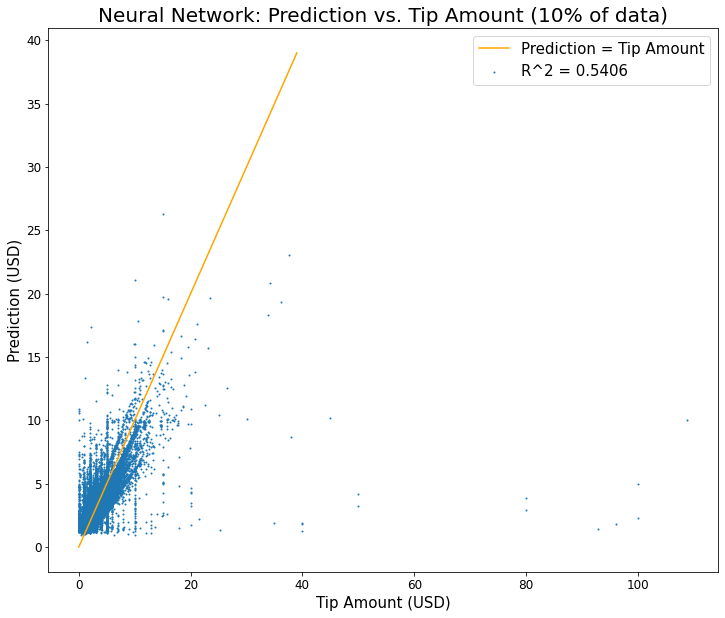

In [56]:
import matplotlib.pyplot as plt
comparison.sort_values(by=['tip_amount'])

# Creating the dataframe to be graphed
x = comparison['tip_amount']
y = comparison['prediction']
NN_df = pd.DataFrame({"x": x, "y":y})
NN_df = NN_df.sample(frac=0.1, random_state=1) # sampling 10% to make the relationship clearer

# prediction = tip amount line
line = range(40)
onetoone = [x for x in range(40)]

# plotting
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(line, onetoone, zorder=1, color = 'orange')
NN_df.plot(kind='scatter', x = 'x', y = 'y',  s = 1, ax = ax, zorder =-1, fontsize = 12) 
ax.set_xlabel("Tip Amount (USD)", fontsize = 15)
ax.set_ylabel("Prediction (USD)", fontsize = 15)
ax.set_title("Neural Network: Prediction vs. Tip Amount (10% of data)", fontsize = 20)
plt.legend([f'Prediction = Tip Amount', f'R^2 = {r2:.4f}'], loc = 'upper right', prop = {'size': 15})
plt.savefig('../plots/Neural Network.png', bbox_inches = 'tight')

The above output shows the prediction values of the neural network compared to the actual tip amounts. the r^2 value is 0.5406 which considering the how much variance there is in tipping as well as how much tipping is dependant on idividuals beliefs, financial situation, generosity etc. I beleive this model is of high quality. (is it to note that these results have removed all instances of no tipping)

## Linear regression

Creating the dataframe with the relavent variables dtermined by the feature selector

In [141]:
df = pd.read_parquet("../data/curated/combined")
df = df.drop(df[df.tip_amount == 0].index)
variables = ['fare_amount', 'trip_distance_km', 'trip_time_min','temp', 'pickup_hour_time']
X = df[variables]
y = df['tip_amount']

Splitting the data into training and testing sets

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

normalising the data

In [143]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

fitting the model to a linear regression

In [144]:
model = LinearRegression()
model = model.fit(X_train, y_train)
model.coef_

array([ 1.40923179,  0.16720049,  0.02439083, -0.00774766,  0.02912525])

Calculating the R^2 value

In [145]:
predictions = model.predict(X_test)
errors = np.array(predictions - y_test)
squared_errors = errors**2
tot_sum_squares = (np.array(y_test - y_test.mean())**2).sum()
r2 = 1 - (squared_errors.sum() / tot_sum_squares)
print(f'Model R^2: {r2:.4f}')

Model R^2: 0.5456


Graphing our results

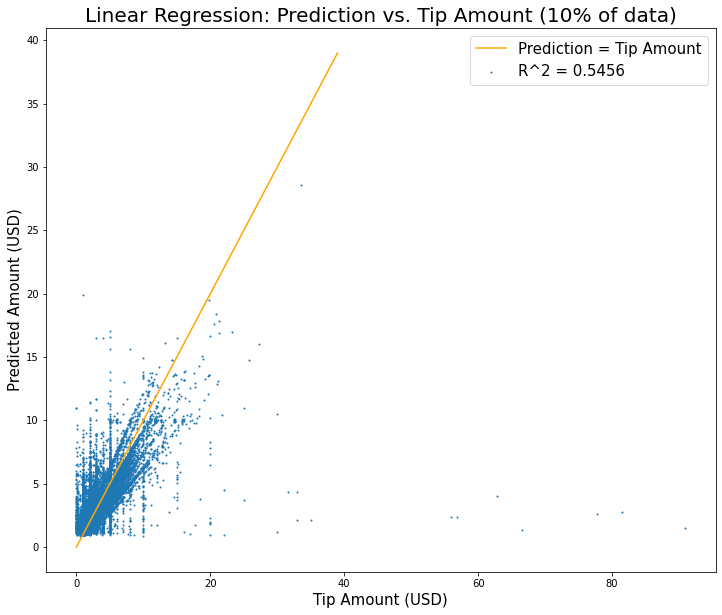

In [146]:
# Creating the dataframe to be graphed
y = predictions
x = y_test
fare_df = pd.DataFrame({"x": x, "y":y})
fare_df = fare_df.sample(frac=0.1, replace=True, random_state=1) # sampling 10% to make the relationship clearer

# prediction = tip amount line
line = range(40)
onetoone = [x for x in range(40)]

# plotting
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(line, onetoone, zorder=1, color = 'orange')
fare_df.plot(kind='scatter', x = 'x', y = 'y', s = 1, ax = ax, zorder =-1) 
ax.set_xlabel('Tip Amount (USD)', fontsize = 15)
ax.set_ylabel('Predicted Amount (USD)', fontsize = 15)
ax.set_title("Linear Regression: Prediction vs. Tip Amount (10% of data)", fontsize = 20)
plt.legend(['Prediction = Tip Amount', f'R^2 = {r2:.4f}'], loc = 'upper right', prop = {'size': 15})
plt.savefig('../plots/Linear Regression.png', bbox_inches = 'tight')

The above shows the relationship between the predicted amount and the actual amount tipped for a linear regression model. with a r^2 value of 0.5456, basdd on the reasons laid out in the neural network section, this is a good result.

### Passive Agressive Regression


Creating a dataframe using the variables produced from the feautre selection

In [168]:
df = pd.read_parquet("../data/curated/combined")
df = df.drop(df[df.tip_amount == 0].index)
variables = ['fare_amount', 'trip_distance_km', 'trip_time_min','temp', 'pickup_hour_time']
X = df[variables]
y = df['tip_amount']

splitting the data into training and testing sets

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Normalising the data

In [170]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Using passive aggressive regression as we have already picked the variables that work best with the model and thus only need to play around with weighting and not removal

Seeing what values of C optimises the model:

In [183]:
from sklearn.linear_model import PassiveAggressiveRegressor
for i in range(1, 10):
    model = PassiveAggressiveRegressor(C=i/10, random_state=1)
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    errors = np.array(predictions - y_test)
    squared_errors = errors**2
    tot_sum_squares = (np.array(y_test - y_test.mean())**2).sum()
    r2 = 1 - (squared_errors.sum() / tot_sum_squares)
    print(f'Model R^2: {r2:.4f}')

Model R^2: 0.4537
Model R^2: 0.4382
Model R^2: 0.4244
Model R^2: 0.3994
Model R^2: 0.3695
Model R^2: 0.3459
Model R^2: 0.3129
Model R^2: 0.2653
Model R^2: 0.2231


it appears that the smaller the value of C the better:

In [190]:
model = PassiveAggressiveRegressor(C = 0.0001)
model.fit(X_train,y_train)
model.coef_

array([ 1.67505085,  0.05998854,  0.01580344, -0.00637437,  0.03465591])

Making predictions based on the model as well as finding the r^2 value

In [186]:
predictions = model.predict(X_test)
errors = np.array(predictions - y_test)
squared_errors = errors**2
tot_sum_squares = (np.array(y_test - y_test.mean())**2).sum()
r2 = 1 - (squared_errors.sum() / tot_sum_squares)
print(f'Model R^2: {r2:.4f}')

Model R^2: 0.5384


grapghing our results

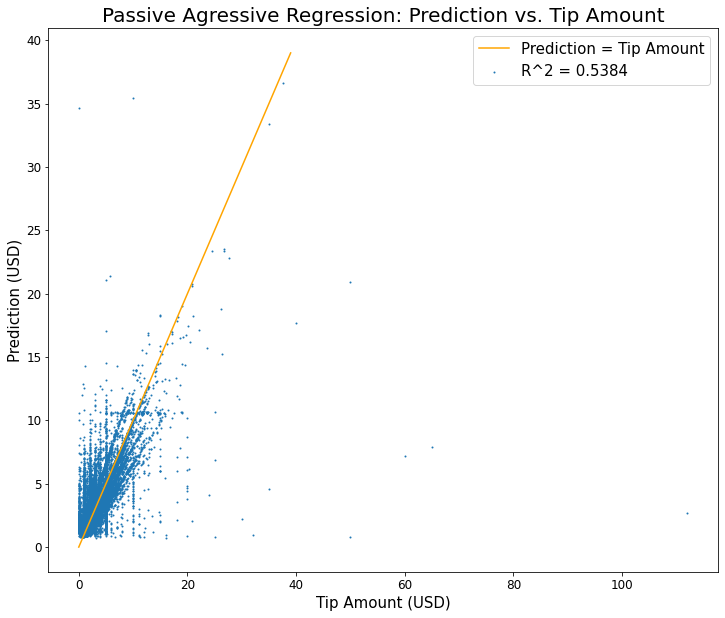

In [188]:
y = predictions
x = y_test
ridge_df = pd.DataFrame({"x": x, "y":y})
ridge_df = ridge_df.sample(frac=0.1, random_state=1)

line = range(40)
onetoone = [x for x in range(40)]

fig, ax = plt.subplots(figsize=(12,10))
ax.plot(line, onetoone, color = 'orange')
ridge_df.plot(kind='scatter', x= 'x', y= 'y', s = 1, ax = ax, zorder =-1, fontsize = 12) 
ax.set_xlabel("Tip Amount (USD)", fontsize = 15)
ax.set_ylabel("Prediction (USD)", fontsize = 15)
ax.set_title("Passive Agressive Regression: Prediction vs. Tip Amount", fontsize = 20)
plt.legend(['Prediction = Tip Amount', f'R^2 = {r2:.4f}'], loc = 'upper right', prop = {'size': 15})
plt.savefig('../plots/Passive Agressive Regression.png', bbox_inches = 'tight')

The above shows the relationship between the predicted amount and the actual amount tipped for a ridge regression model. with a r^2 value of 0.5384, based on the reasons laid out in the neural network section, this is a good result.